# Final Project Virtual Internship Xperience Kalbe Nutiritonals by Bastian Armananta

Projek ini adalah final project dari Virtual Internship Xperierience dari Kalbe Nutritionals Data Scientist diadakan oleh [Rakamin Academy.](https://www.rakamin.com/virtual-internship-experience/explore) Projek ini akan membuat dua studi kasus dari tim inventory dan marketing sebagai berikut :
1. tim inventory meminta untuk melakukan prediksi penjualan dari total keseluruhan data prodak kalbe.
2. tim marketing diminta untuk segmentasi pelanggan sehingga mendapatkan insight terhadap segmentasi pelanggan perusahaan kalbe.

# Importing Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load All Data

In [ ]:
# Load all data
df_product = pd.read_csv('/content/Case Study - Product.csv', delimiter=';')
df_customer = pd.read_csv('/content/Case Study - Customer.csv', delimiter=';')
df_store = pd.read_csv('/content/Case Study - Store.csv', delimiter=';')
df_transaction = pd.read_csv('/content/Case Study - Transaction.csv', delimiter=';')

Case Study - Legend :

Dataset ini terdiri dari 4 csv file yaitu customer, store, product dan transaction. Merupakan dummy data untuk studi kasus FMCG dalam kurun waktu 1 tahun yang diambil melalui program membership.

Penjelasan
1. Customer
- CustomerID : No Unik Customer
- Age : Usia Customer
- Gender : 0 Wanita, 1 Pria
- Marital Status : Married, Single (Blm menikah/Pernah menikah)
- Income : Pendapatan per bulan dalam jutaan rupiah

2. Store
- StoreID : Kode Unik Store
- StoreName : Nama Toko
- GroupStore : Nama group
- Type : Modern Trade, General Trade
- Latitude : Kode Latitude
- Longitude : Kode Longitude

3. Product
- ProductID : Kode Unik Product
- Product Name : Nama Product
- Price : Harga dlm rupiah

4. Transaction
- TransactionID : Kode Unik Transaksi
- Date : Tanggal transaksi
- Qty : Jumlah item yang dibeli
- Total Amount : Price x Qty


In [ ]:
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [ ]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [ ]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [ ]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [ ]:
df_transaction.tail()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
5015,TR54423,243,31/12/2022,P10,15000,5,75000,3
5016,TR5604,271,31/12/2022,P2,3200,4,12800,9
5017,TR81224,52,31/12/2022,P7,9400,6,56400,9
5018,TR85016,18,31/12/2022,P8,16000,3,48000,13
5019,TR85684,55,31/12/2022,P8,16000,1,16000,6


# Sale Product Prediction using ARIMA

Tujuan dari pembuatan model machine learning ini adalah untuk dapat memprediksi total quantity harian dari product yang terjual.

## Data Merge

In [ ]:
# Data Merge
# Merge all relevant datasets (customer, product, store, transaction)
merged_data = pd.merge(df_transaction, df_customer, on='CustomerID')
merged_data = pd.merge(merged_data, df_product, on='ProductID')
merged_data = pd.merge(merged_data, df_store, on='StoreID')

Setelah melakukan merging seluruh dataset yang disesuaikan dengan primary key, kita dapat melakukan analisis terhadap data lebih lanjut.

In [ ]:
merged_data.describe()

,CustomerID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Price_y
count,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000
mean,221.263745,9684.800797,3.644622,32279.482072,7.489841,40.003586,0.452988,9684.800797
std,129.672955,4600.708780,1.855295,19675.462455,4.028502,12.834719,0.497835,4600.708780
min,1.000000,3200.000000,1.000000,7500.000000,1.000000,0.000000,0.000000,3200.000000
25%,108.000000,4200.000000,2.000000,16000.000000,4.000000,30.000000,0.000000,4200.000000
50%,221.000000,9400.000000,3.000000,28200.000000,7.000000,39.000000,0.000000,9400.000000
75%,332.000000,15000.000000,5.000000,47000.000000,11.000000,51.000000,1.000000,15000.000000
max,447.000000,18000.000000,10.000000,88000.000000,14.000000,72.000000,1.000000,18000.000000


In [ ]:
merged_data.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,Price_y,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,36,0,Married,"10,53",Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
1,TR89318,183,17/07/2022,P3,7500,1,7500,12,27,1,Single,"0,18",Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
2,TR9106,123,26/09/2022,P3,7500,4,30000,12,34,0,Married,"4,36",Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
3,TR4331,335,08/01/2022,P3,7500,3,22500,12,29,1,Single,"4,74",Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
4,TR6445,181,10/01/2022,P3,7500,4,30000,12,33,1,Married,"9,94",Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"


In [ ]:
merged_data.tail()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,Price_y,StoreName,GroupStore,Type,Latitude,Longitude
5015,TR69555,221,01/08/2022,P4,12000,3,36000,4,23,1,Single,"7,5",Potato Chip,12000,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
5016,TR21587,425,17/10/2022,P4,12000,1,12000,4,58,1,Married,"7,22",Potato Chip,12000,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
5017,TR51183,409,19/07/2022,P4,12000,1,12000,4,47,0,Married,"28,23",Potato Chip,12000,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
5018,TR14963,374,16/12/2022,P4,12000,5,60000,4,32,0,Single,"5,4",Potato Chip,12000,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
5019,TR40750,271,30/11/2022,P4,12000,3,36000,4,29,0,Married,"4,74",Potato Chip,12000,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"


In [ ]:
merged_data.isnull().sum()

TransactionID      0
CustomerID         0
Date               0
ProductID          0
Price_x            0
Qty                0
TotalAmount        0
StoreID            0
Age                0
Gender             0
Marital Status    44
Income             0
Product Name       0
Price_y            0
StoreName          0
GroupStore         0
Type               0
Latitude           0
Longitude          0
dtype: int64

In [ ]:
merged_data['Marital Status'].value_counts()

Married    3779
Single     1197
Name: Marital Status, dtype: int64

Berdasarkan code diatas dapat kita lihat bahwa kolom `Marital Status` terdapat nilai kosong sebanyak 44, namun task disini adalah untuk melakukan development terhadap prediktif model regresi terhadap kolom `Qty`, sehingga kolom selain itu tidak terlalu penting

## Data Agregation

In [ ]:
# Creating new dataset
daily_quantity = merged_data.groupby('Date')['Qty'].sum().reset_index()

Langkah selanjutnya adalah dengan melakukan `sum()` terhadap kolom `Qty` dengan memperhatikan kolom `Date`, sehingga jika ada transaksi prodak dengan tanggal yang sama akan dijumlahkan dan kita akan mendapatkan data total kuantiti prodak yang dibeli pada masing masing tanggal.

In [ ]:
daily_quantity

,Date,Qty
0,01/01/2022,49
1,01/02/2022,50
2,01/03/2022,76
3,01/04/2022,98
4,01/05/2022,67
...,...,...
360,31/05/2022,21
361,31/07/2022,72
362,31/08/2022,36
363,31/10/2022,69


In [ ]:
# Converse date column into datetime type
daily_quantity['Date'] = pd.to_datetime(daily_quantity['Date'])

<ipython-input-14-24fc67ed081c>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  daily_quantity['Date'] = pd.to_datetime(daily_quantity['Date'])


In [ ]:
# Count average first 100 data
mean_qty = daily_quantity['Qty'][:100].mean()

## Visualize 100 Data Sample

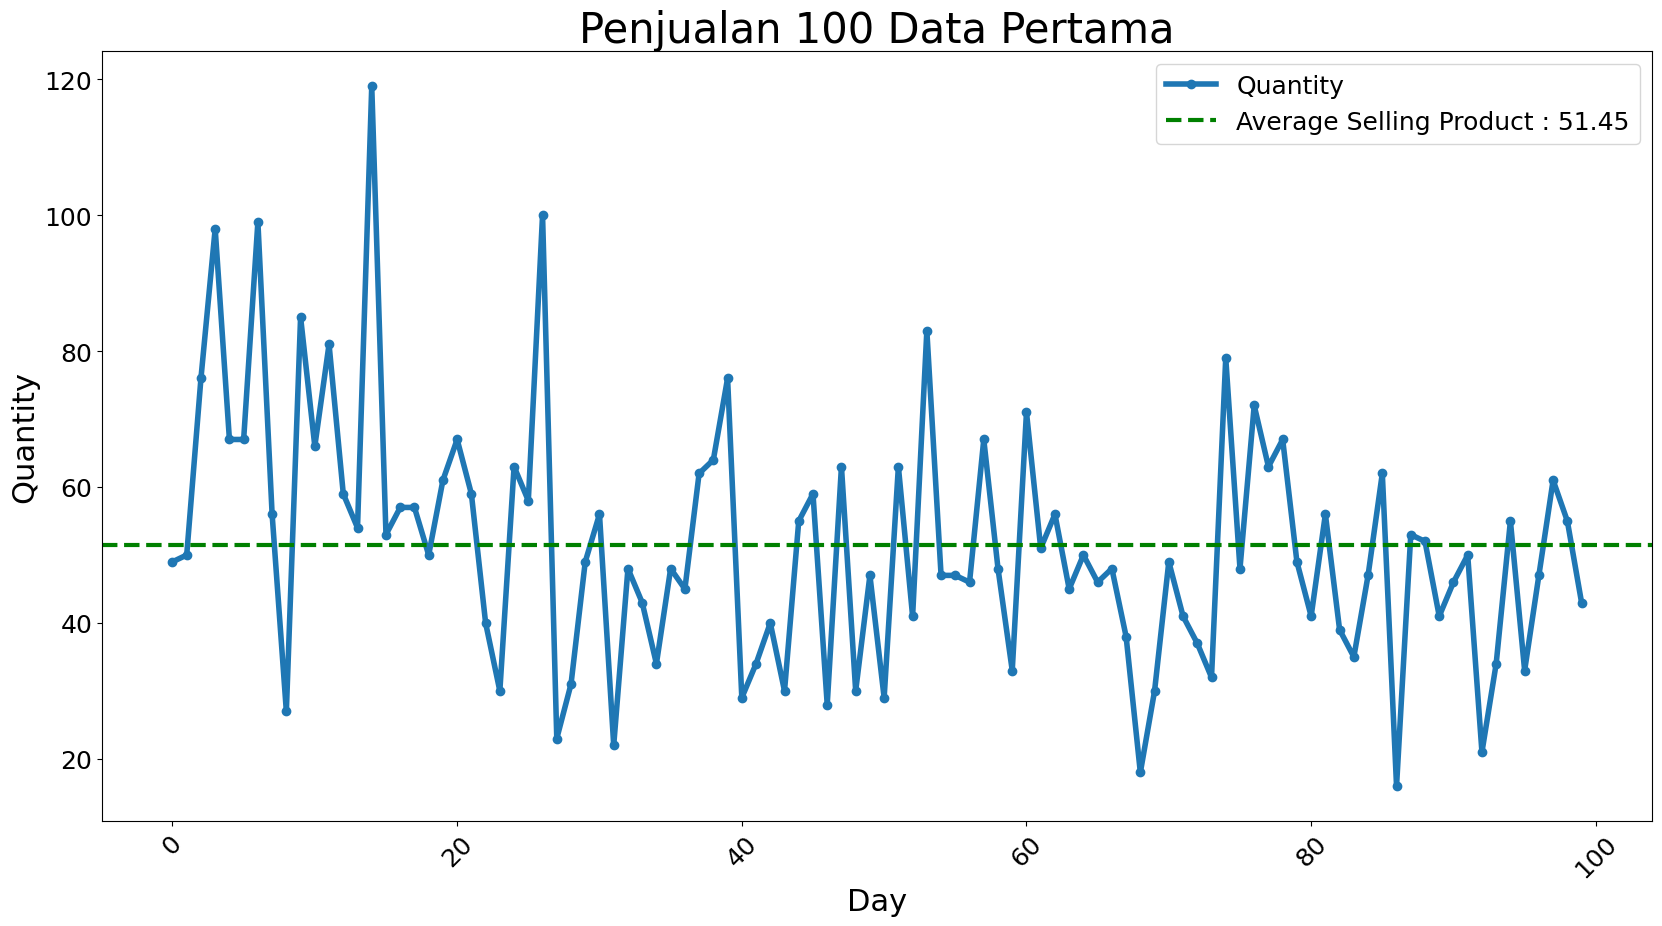

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(daily_quantity['Qty'][:100], linewidth=4, marker='o', label='Quantity')
plt.axhline(y=daily_quantity['Qty'][:100].mean(), linewidth=3, color='green', linestyle='--', label=f'Average Selling Product : {mean_qty:.2f}')
plt.title('Penjualan 100 Data Pertama', fontsize=30)
plt.ylabel('Quantity', fontsize=22)
plt.legend(fontsize=18)

plt.xlabel('Day', fontsize=22)
plt.xticks(rotation=45)

plt.tick_params(axis='both', which='both', labelsize=18)
plt.legend(prop={'size': 18})

Berdasarkan visualisasi diatas, dapat diambil kesimpulan bahwa rata rata pembelian prodak pada 100 data pertama adalah sejumlah 51.45 data dengan pembelian tertinggi terdapat pada pertengahan bulan januari dan februari, namun secara keseluruhan dari 100 data pertama menampilkan performa dengan fluktuasi yang tinggi dengan trend dari bulan januari sampai april yang menurun.

In [ ]:
# Set the Date column as the index
daily_quantity.set_index('Date', inplace=True)

## Stationary Test Data

In [ ]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adfuller_test(daily_quantity['Qty'])

ADF Test Statistic : -19.09810117481214
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 364
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Sebelum melakukan tahap training kita harus memastikan bahwa data yang akan kita melaui uji stationeritas, uji stationeritas dapat dilakukan melalui library `adfuller` dengan memperhatikan p-value, jika p-value dibawah 0.05 maka data dikatakan stationer dan dapat dilakukan ke tahap selanjutnya yaitu modelling, sebaliknya jika data menghasilkan angka lebih dari sama dengan 0.05 maka data tidak dapat dilanjutkan ke tahapan selanjutnya, ketika kondisi ini terjadi dapat dilakukan teknik `windowing` dengan melakukan shifting pada library pandas agar mengubah data kedalam kategori `non stationer`.

## Training using ARIMA

In [ ]:
# Apply ARIMA model
model = ARIMA(daily_quantity['Qty'], order=(1, 1, 1))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

## Predict 30 Day in Future

In [ ]:
# Perform the forecast for one month ahead
forecast = model_fit.get_forecast(steps=30)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
confidence_interval = forecast.conf_int()

In [ ]:
confidence_interval['upper Qty'].mean()

82.85270928930801

## Analyze Predicted Data

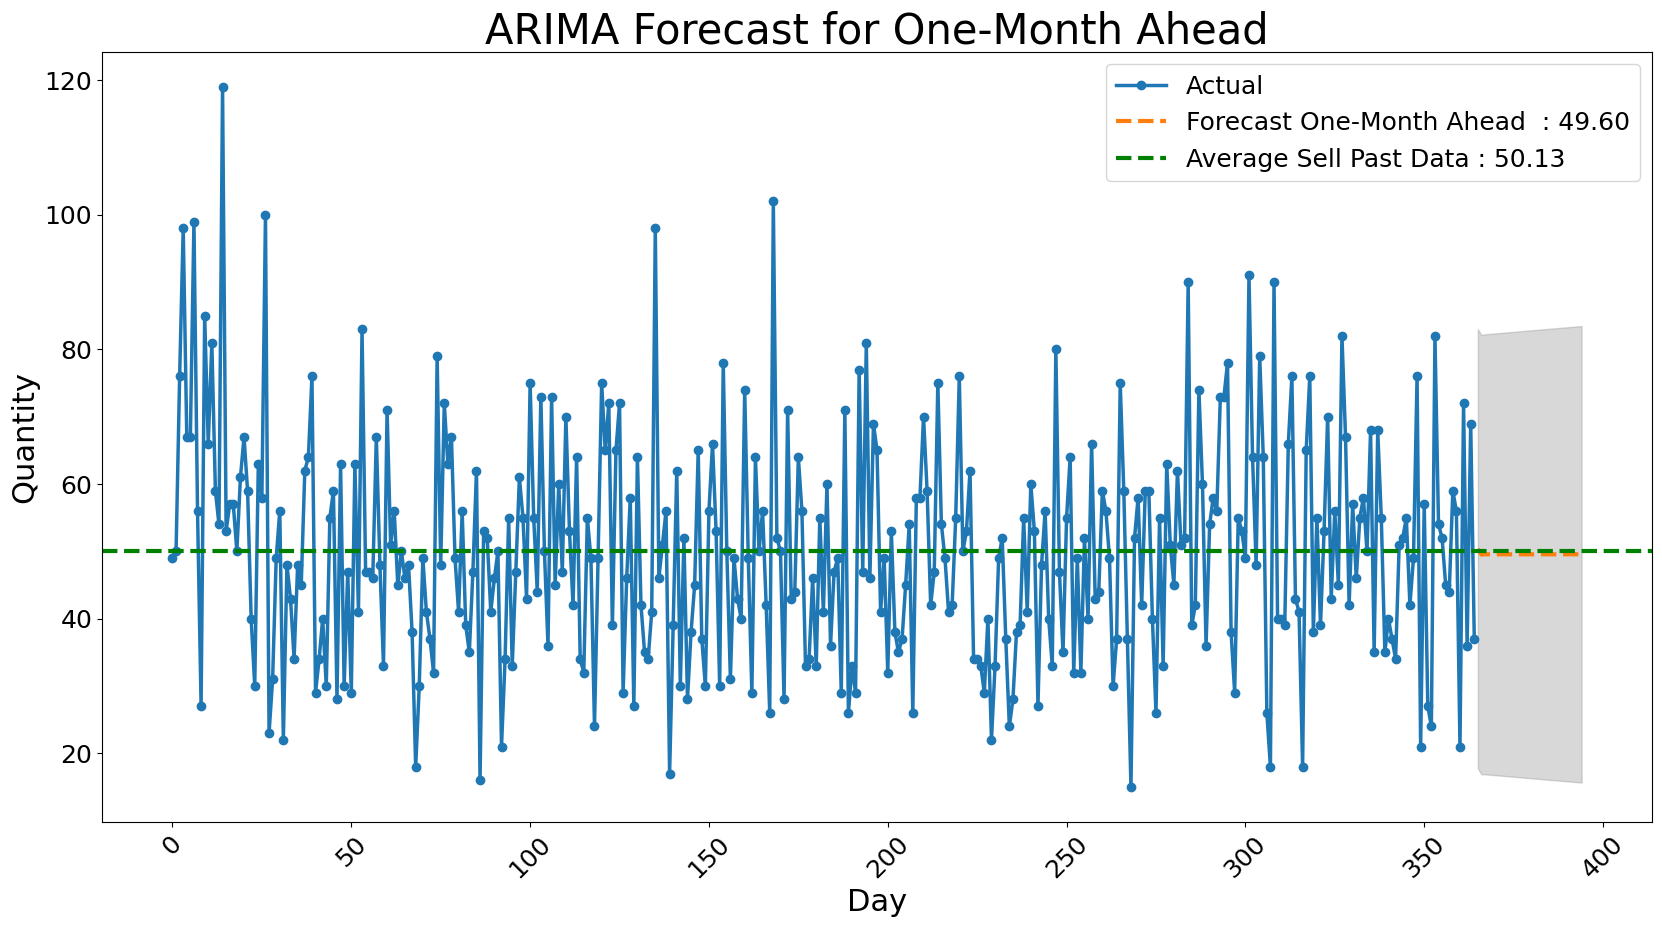

In [ ]:
# Visualize the forecast
mean_product = daily_quantity['Qty'].mean()
mean_forecast = forecast_values.mean()

plt.figure(figsize=(20, 10))
plt.plot(daily_quantity['Qty'].values, label='Actual', linewidth=2.5, marker='o')
plt.plot(forecast_values, label=f'Forecast One-Month Ahead  : {mean_forecast:.2f}', linewidth=3, linestyle='--')
plt.axhline(y=daily_quantity['Qty'].mean(), linewidth=3, color='green', linestyle='--', label=f'Average Sell Past Data : {mean_product:.2f}')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='gray', alpha=0.3)
plt.legend()
plt.xlabel('Day', fontsize=22)
plt.ylabel('Quantity', fontsize=22)
plt.title('ARIMA Forecast for One-Month Ahead', fontsize=30)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='both', labelsize=18)
plt.legend(prop={'size': 18})

In [ ]:
(49.6-50.1)/50.1*100

-0.998003992015968

Berdasarjan visualisasi diatas maka dapat dikatakan bahwa rata rata selama satu tahun penjualan sebesar `50.13`, selama satu tahun penjualan menunjukan nilai dengan trend yang sangat fluktuatif pada masing masing bulannya. Grafik berwarna oranye menunjukan prediksi satu bulan setelahnya, terdapat penurunan yang sedikit pada rata rata penjualan tahun lalu dengan rata rata prediksi satu bulan kedepan, tepatnya sebesar `0.53` selain itu prediksi juga menunjukan interval yang cukup jauh dari nilai maksimal dan nilai minimal, sehingga semakin tinggi perbedaan nilai tersebut akan menghasilkan berbanding lurus dengan tingkat fluktuatif prediksi penjualan prodak.

# Customer Segmentation using KMeans

## Data Merge

In [ ]:
merged_data = pd.merge(df_customer, df_transaction, on='CustomerID')
merged_data = pd.merge(merged_data, df_store, on='StoreID')

Data merging dilakukan untuk menyatukan data customer dan transaction dengan memperhatikan `CustomerID` serta menggabungkan variabel `merge_data` dengan data store dengan memperhatikan `StoreID`.

In [ ]:
merged_data

,CustomerID,Age,Gender,Marital Status,Income,TransactionID,Date,ProductID,Price,Qty,TotalAmount,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,55,1,Married,"5,12",TR54475,23/02/2022,P8,16000,1,16000,9,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
1,1,55,1,Married,"5,12",TR60228,01/07/2022,P3,7500,5,37500,9,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
2,2,60,1,Married,"6,23",TR13287,15/01/2022,P5,4200,2,8400,9,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
3,4,31,1,Married,"4,87",TR65982,29/03/2022,P5,4200,4,16800,9,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
4,5,58,1,Married,"3,57",TR49638,28/04/2022,P4,12000,1,12000,9,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,443,33,1,NaN,"9,28",TR81388,30/10/2022,P5,4200,4,16800,10,Harapan Baru,Harapan Baru,General Trade,"3,597031","98,678513"
5016,445,51,0,Married,"14,48",TR43384,11/09/2022,P7,9400,5,47000,10,Harapan Baru,Harapan Baru,General Trade,"3,597031","98,678513"
5017,445,51,0,Married,"14,48",TR68183,20/11/2022,P5,4200,3,12600,10,Harapan Baru,Harapan Baru,General Trade,"3,597031","98,678513"
5018,446,57,0,Married,"7,81",TR61518,25/03/2022,P8,16000,2,32000,10,Harapan Baru,Harapan Baru,General Trade,"3,597031","98,678513"


## Data Agregation

In [ ]:
# Membuat Data Baru untuk Clustering
clustering_data = merged_data.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'Qty': 'sum',
    'TotalAmount': 'sum'
})

Variabel `clustering_data` melakukan grouping pada kolom `CustomerID` dengan melakukan agregasi pada `TransactionID` dengan menghitung seberapa banyak dia melakukan transaksi, selanjutnya dalah melakukan penjumlahan pada kolom `Qty` pada seluruh transaksi customer id serta menjumlahkan seluruh `TotalAmount` sehingga menghasilkan keseluruhan jumlah berdasarkan `TransactionID` dan `Qty`.

In [ ]:
clustering_data

,TransactionID,Qty,TotalAmount
CustomerID,,,
1,17,60,623300
2,13,57,392300
3,15,56,446200
4,10,46,302500
5,7,27,268600
...,...,...,...
443,16,59,485100
444,18,62,577700
445,18,68,587200


## Visualize Data using Scatter Plot

Text(0, 0.5, 'TotalAmount')

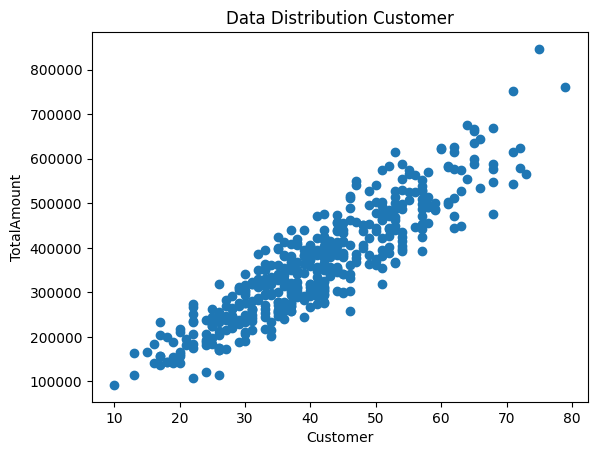

In [ ]:
plt.scatter(clustering_data.Qty, clustering_data.TotalAmount)
plt.title('Data Distribution Customer')
plt.xlabel('Customer')
plt.ylabel('TotalAmount')

## Preprocessing

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(clustering_data[['Qty']])
y_scaled = scaler.fit_transform(clustering_data[['TotalAmount']])

Melakukan scaling menggunakan `MinMaxScaler` dengan melakukan ubahan terhadap jarak angka, dimana angka 0 adalah representatif angka terkecil dan angka 1 adalah representatif adalah angka terbesar pada kolom `Qty` dan `TotalAmount`. Hal ini dilakukan untuk memperkecil kalkukasi sehingga data akan lebih efisien.

## Elbow Method

In [ ]:
k = []
for i in range(1,11):
  model = KMeans(n_clusters=i)
  model.fit(X_scaled, y_scaled)
  k.append(model.inertia_)
  score = silhouette_score(X_scaled, y_scaled)
  print(f"For k = {i}, the silhouette score is: {score:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k = 1, the silhouette score is: -0.12


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k = 2, the silhouette score is: -0.12


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/loc

For k = 3, the silhouette score is: -0.12
For k = 4, the silhouette score is: -0.12
For k = 5, the silhouette score is: -0.12
For k = 6, the silhouette score is: -0.12
For k = 7, the silhouette score is: -0.12
For k = 8, the silhouette score is: -0.12
For k = 9, the silhouette score is: -0.12
For k = 10, the silhouette score is: -0.12


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 1.0, 'Elbow Method')

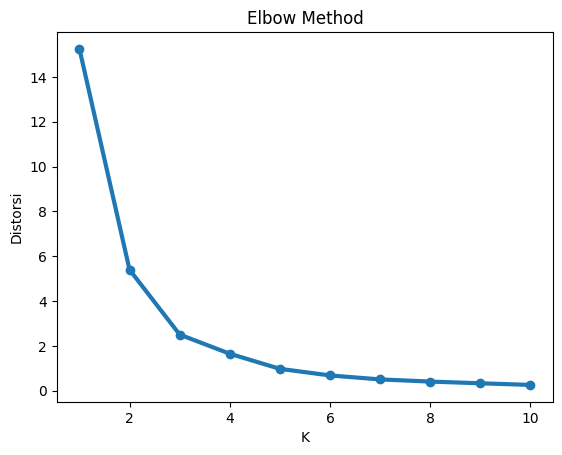

In [ ]:
plt.plot(list(range(1, 11)), k, marker='o', linewidth=3)
plt.ylabel('Distorsi')
plt.xlabel('K')
plt.title("Elbow Method")

Elbow method digunakan untuk menentukan jumlah cluster yang `efisien`, pemilihan jumlah cluster dapat diambil dengan indikasi daerah dengan `patahan` sebelum landai, sehingga dalam task ini saya mengambil `K=3` untuk menentukan cluster karena jika memilih cluster lebih dari `3` maka data akan menunjukan kelandaian, sebaliknya jika memilih cluster `2` atau `1` pembagian cluster tidak efisien karena masih sangat menurun.

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_scaled, y_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [ ]:
cluster_labels = kmeans.labels_
centroid = kmeans.cluster_centers_

In [ ]:
centroid

array([[0.69082126],
       [0.23686248],
       [0.44483286]])

In [ ]:
clustering_data['Cluster'] = cluster_labels
clustering_data['Qty_scaled'] = X_scaled
clustering_data['TotalAmount_scaled'] = y_scaled

In [ ]:
clustering_data

,TransactionID,Qty,TotalAmount,Cluster,Qty_scaled,TotalAmount_scaled
CustomerID,,,,,,
1,17,60,623300,0,0.724638,0.703949
2,13,57,392300,0,0.681159,0.397827
3,15,56,446200,0,0.666667,0.469255
4,10,46,302500,2,0.521739,0.278823
5,7,27,268600,1,0.246377,0.233899
...,...,...,...,...,...,...
443,16,59,485100,0,0.710145,0.520806
444,18,62,577700,0,0.753623,0.643520
445,18,68,587200,0,0.840580,0.656109


## Analyze Cluster

Text(0, 0.5, 'TotalAmount')

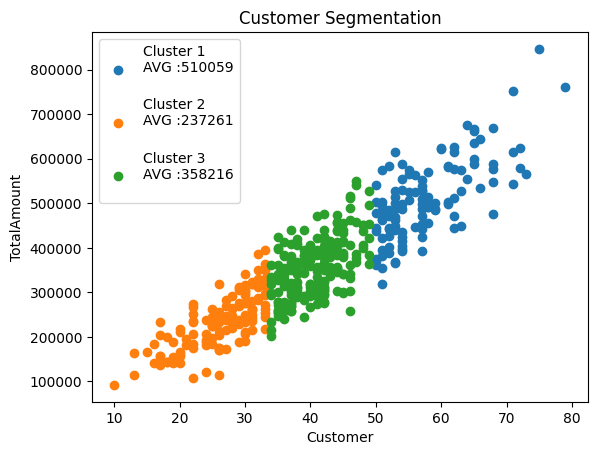

In [ ]:
cluster0 = clustering_data[clustering_data['Cluster'] == 0]
cluster1 = clustering_data[clustering_data['Cluster'] == 1]
cluster2 = clustering_data[clustering_data['Cluster'] == 2]

cluster0_mean = cluster0['TotalAmount'].mean()
cluster1_mean = cluster1['TotalAmount'].mean()
cluster2_mean = cluster2['TotalAmount'].mean()

plt.scatter(cluster0['Qty'], cluster0['TotalAmount'], label=f'Cluster 1\nAVG :{cluster0_mean:.0f}\n')
plt.scatter(cluster1['Qty'], cluster1['TotalAmount'], label=f'Cluster 2\nAVG :{cluster1_mean:.0f}\n')
plt.scatter(cluster2['Qty'], cluster2['TotalAmount'], label=f'Cluster 3\nAVG :{cluster2_mean:.0f}\n')
plt.legend()
plt.title("Customer Segmentation")
plt.xlabel('Customer')
plt.ylabel('TotalAmount')

Berdasarkan visualisasi diatas, dapat dilihat terdapat 3 segemen, mari kita sebut sebagai menengah ke bawah, menengah, dan menengah ke atas, hal ini dapat dilakukan sales treatment yang lebih bersifat personal terhadap masing masing segmentasi.

1. Menengah Kebawah:

*   Segmentasi ini mewakili pelanggan dengan jumlah transaksi, total jumlah barang yang dibeli, dan total jumlah uang yang dibelanjakan yang relatif lebih rendah.
*   Pelanggan dalam segmen ini mungkin memiliki keterbatasan finansial atau preferensi belanja yang lebih hemat.
*   Strategi pemasaran yang tepat untuk segmen ini mungkin melibatkan penawaran harga terjangkau, diskon, atau penawaran khusus untuk menarik pelanggan dalam segmen ini.

2. Menengah:

*   Segmentasi ini mewakili pelanggan dengan jumlah transaksi, total jumlah barang yang dibeli, dan total jumlah uang yang dibelanjakan yang berada di kisaran menengah.
*   Pelanggan dalam segmen ini cenderung memiliki kebiasaan belanja yang stabil dan melakukan pembelian dengan frekuensi yang moderat.
*   Strategi pemasaran untuk segmen ini bisa berfokus pada mempertahankan loyalitas pelanggan dengan menawarkan program loyalitas, penghargaan, atau promosi berkelanjutan.

3. Menengah Keatas:

*   Segmentasi ini mewakili pelanggan dengan jumlah transaksi, total jumlah barang yang dibeli, dan total jumlah uang yang dibelanjakan yang relatif lebih tinggi.
*   Pelanggan dalam segmen ini cenderung memiliki daya beli yang kuat dan mungkin memiliki preferensi untuk produk atau layanan premium.
*   Strategi pemasaran yang efektif untuk segmen ini bisa melibatkan penawaran produk atau layanan yang berkualitas tinggi, pengalaman pelanggan yang unik, atau program eksklusif yang memberikan nilai tambah.